In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats as ss

In [35]:
data_main = pd.read_csv('./odi_score.csv')
data = data_main.drop('Unnamed: 0', axis=1)
#data.to_csv('./odi_score.csv')
data.reset_index(inplace=True)

In [36]:
unique_bowl_values = list(data['bowling_team'].unique())
unique_bat_values = list(data['batting_team'].unique())

unique_team = list(zip(unique_bat_values, unique_bowl_values))
print(unique_team)

[('Australia', 'Pakistan'), ('Pakistan', 'Australia'), ('New Zealand', 'New Zealand'), ('South Africa', 'Bangladesh'), ('Bangladesh', 'South Africa'), ('India', 'England'), ('England', 'Sri Lanka'), ('Sri Lanka', 'India'), ('West Indies', 'West Indies'), ('Afghanistan', 'Afghanistan')]


In [37]:
total_na_values = data.isnull().sum()
null_values = (total_na_values/data.isnull().count())
missing_data = pd.concat([total_na_values, null_values], axis=1, keys=['Total', 'In %'])
missing_cols = (missing_data[missing_data.Total > 0]).index
print(missing_cols)

Index(['last_five'], dtype='object')


In [38]:
data.fillna(0, inplace=True)
data.drop(['index', 'match_id'], axis=1, inplace=True)

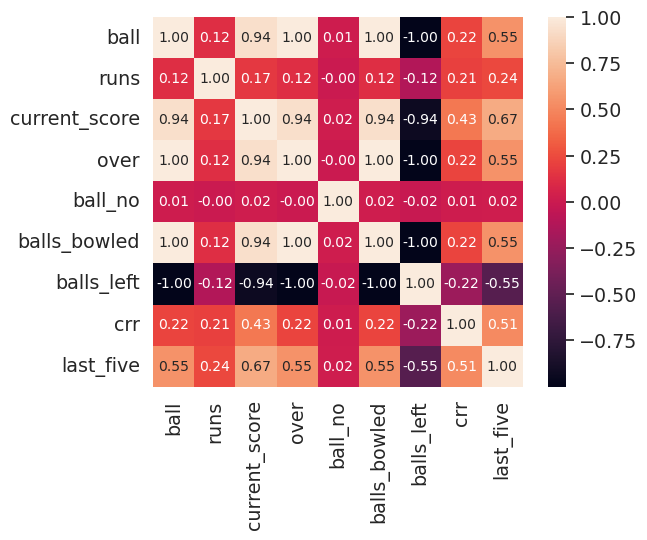

In [39]:
def generate_heatmap(df, target_col):
    num_cols = [col for col in data if data[col].dtype in ['int64', 'float64']]
    corr_mat = df[num_cols].corr()
    cols = corr_mat[target_col].index
    cm = np.corrcoef(data[cols].values.T)
    sns.set(font_scale=1.25);
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    
generate_heatmap(data, 'runs')

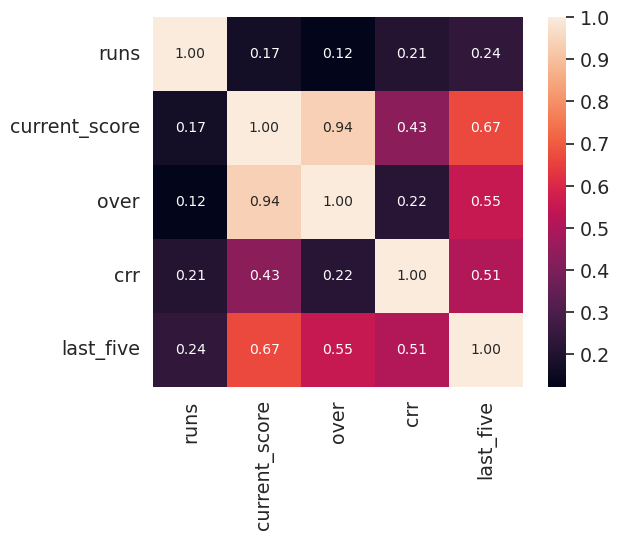

In [40]:
data = data.drop(['ball', 'balls_bowled', 'ball_no', 'balls_left'], axis=1)
generate_heatmap(data, 'runs')

In [52]:
#sns.pairplot(data)
X = data.copy()
y = data['current_score']
X.drop(['current_score'], axis=1, inplace=True)

In [111]:
#data.to_csv('clean_data.csv')
def get_over(df=data, row_idx=0):
    return df.loc[row_idx]['over']
rows = data.shape[0]
last_ball_count = 6 
overs = []
curr = get_over(data, last_ball_count) 
next_ = get_over(data, last_ball_count+1)

while last_ball_count < 50:
    if curr != next_:
        last_ball_count = last_ball_count + 1
    else:
        last_ball_count = last_ball_count + 6 

    curr = get_over(data, last_ball_count-1)
    next_ = get_over(data, last_ball_count)
    print(curr, last_ball_count)

0 7
1 8
2 14
3 20
4 26
5 32
5 38
6 39
7 45
8 51


In [44]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor

cat_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values='None', fill_value='None')),
    ('ohe', OneHotEncoder(sparse=False, drop='First', handle_unknown='ignore'))
])

transform_col = ColumnTransformer(transformers=[
    cat_pipe
])

model = RandomForestRegressor() 
pipe = Pipeline(steps=[
    ('transformer', transform_col),
    ('model', model)
])